In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
print("🔹 Checking GPU availability...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


🔹 Checking GPU availability...
✅ Using device: cuda


In [3]:
print("\n🔹 Loading CIFAR-10 dataset...")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# smaller subset for faster demo
subset_size = 5000
train_dataset, _ = random_split(dataset, [subset_size, len(dataset) - subset_size])
test_subset_size = 1000
test_dataset, _ = random_split(test_dataset, [test_subset_size, len(test_dataset) - test_subset_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("✔ Dataset loaded successfully!")



🔹 Loading CIFAR-10 dataset...


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified
✔ Dataset loaded successfully!


In [5]:
print("\n🔹 Loading Pre-trained ResNet50 model...")
model = models.resnet50(pretrained=True)

# Freeze convolutional layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 10),
    nn.LogSoftmax(dim=1)
)

model = model.to(device)
print("✔ Model prepared successfully (ResNet50)!")


🔹 Loading Pre-trained ResNet50 model...
✔ Model prepared successfully (ResNet50)!


In [6]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)

In [7]:
print("\n🔹 Starting training...")
epochs = 3
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model(inputs)
            batch_loss = criterion(logps, labels)
            val_loss += batch_loss.item()
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class.view(-1) == labels
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

    train_losses.append(running_loss / len(train_loader))
    val_losses.append(val_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {running_loss/len(train_loader):.3f}.. "
          f"Val loss: {val_loss/len(test_loader):.3f}.. "
          f"Val accuracy: {accuracy/len(test_loader):.3f}")

print("\n✔ Training complete!")



🔹 Starting training...
Epoch 1/3.. Train loss: 1.943.. Val loss: 1.537.. Val accuracy: 0.657
Epoch 2/3.. Train loss: 1.387.. Val loss: 1.134.. Val accuracy: 0.729
Epoch 3/3.. Train loss: 1.114.. Val loss: 0.978.. Val accuracy: 0.727

✔ Training complete!


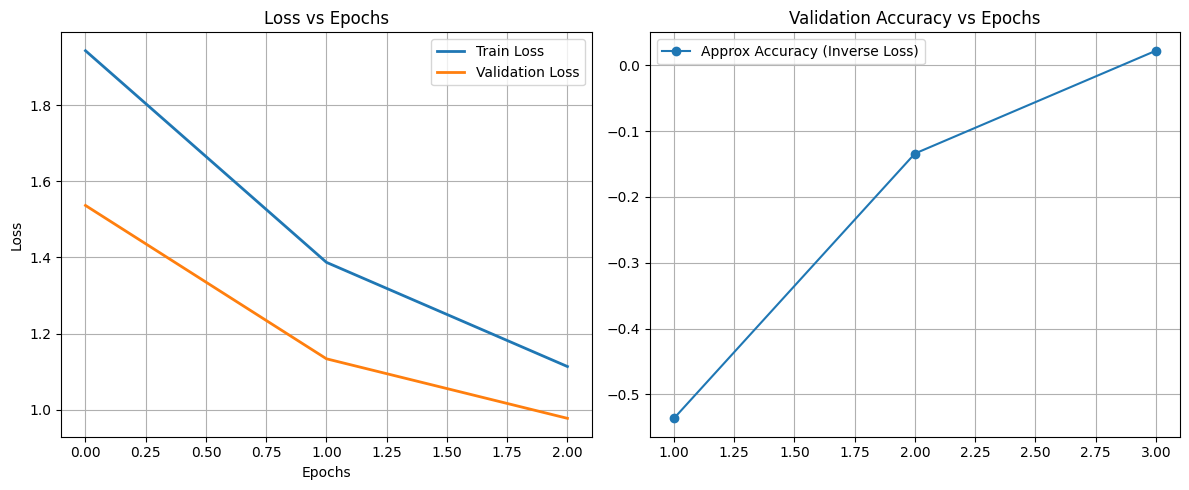

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.title("Validation Accuracy vs Epochs")
plt.plot(range(1, epochs+1),
         [1 - val for val in val_losses], 'o-', label="Approx Accuracy (Inverse Loss)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
print("\n🔹 Evaluating model performance...")
start_time = time.time()
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = torch.exp(outputs).argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print("\n📊 Classification Report:\n")
print(classification_report(all_labels, all_preds,
      target_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']))

print("\n📈 Confusion Matrix:\n")
print(confusion_matrix(all_labels, all_preds))

print("\n✅ Total Execution Time: {:.2f} seconds".format(time.time() - start_time))


🔹 Evaluating model performance...

📊 Classification Report:

              precision    recall  f1-score   support

    airplane       0.80      0.79      0.79        99
  automobile       0.87      0.76      0.81       104
        bird       0.75      0.49      0.59       108
         cat       0.52      0.65      0.58        99
        deer       0.61      0.66      0.63        85
         dog       0.68      0.74      0.71        99
        frog       0.80      0.75      0.77       115
       horse       0.74      0.72      0.73        93
        ship       0.81      0.86      0.84       102
       truck       0.75      0.89      0.81        96

    accuracy                           0.73      1000
   macro avg       0.73      0.73      0.73      1000
weighted avg       0.74      0.73      0.73      1000


📈 Confusion Matrix:

[[78  3  1  3  1  1  0  0  9  3]
 [ 3 79  0  1  1  0  1  1  1 17]
 [ 9  0 53 12 12  6  9  5  2  0]
 [ 1  1  1 64  9 12  5  2  3  1]
 [ 1  0  0  7 56  3  4 11